The dataset is a collection of almost 1000 songs that have the most plays on spoitify. It has 24 columns per row including some interesting less quantifiable columns such as "Dancibility%". I want to use of some these more odd columns to see if I can make other predictions about the songs themselves. By using these columns and a mix of other more quantifiable columns such as BPM, Key, and number of playlists the song has been added too I want to try and predict how many plays a song has. 

In [611]:
#we start with loading and cleaning the data
import pandas as pd

#encoding had to be changed to handle characters in the data not in default UTF-8 encoding
spotify_df = pd.read_csv('spotify-2023.csv', encoding='latin-1')
print("Shape before cleaning data: ", spotify_df.shape)
spotify_df = spotify_df.dropna()
spotify_df = spotify_df.drop_duplicates()
spotify_df = spotify_df[['streams', 'in_spotify_playlists', 'in_shazam_charts', 'in_apple_playlists', 'bpm', 'key', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']]
print("Shape after cleaning data: ", spotify_df.shape)

#We now want to transform categorical variables into numeric
spotify_df['key'] = spotify_df['key'].map({'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5, 'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11})
spotify_df = spotify_df.replace({',':''}, regex=True) 
spotify_df.head(1000)

Shape before cleaning data:  (953, 24)
Shape after cleaning data:  (817, 13)


,streams,in_spotify_playlists,in_shazam_charts,in_apple_playlists,bpm,key,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,141381703,553,826,43,125,11,80,89,83,31,0,8,4
1,133716286,1474,382,48,92,1,71,61,74,7,0,10,4
2,140003974,1397,949,94,138,5,51,32,53,17,0,31,6
3,800840817,7858,548,116,170,9,55,58,72,11,0,11,15
4,303236322,3133,425,84,144,9,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,91473363,953,0,61,144,9,60,24,39,57,0,8,3
949,121871870,1180,0,4,166,6,42,7,24,83,1,12,6
950,73513683,573,0,2,92,1,80,81,67,4,0,8,6
951,133895612,1320,0,29,97,1,82,67,77,8,0,12,5


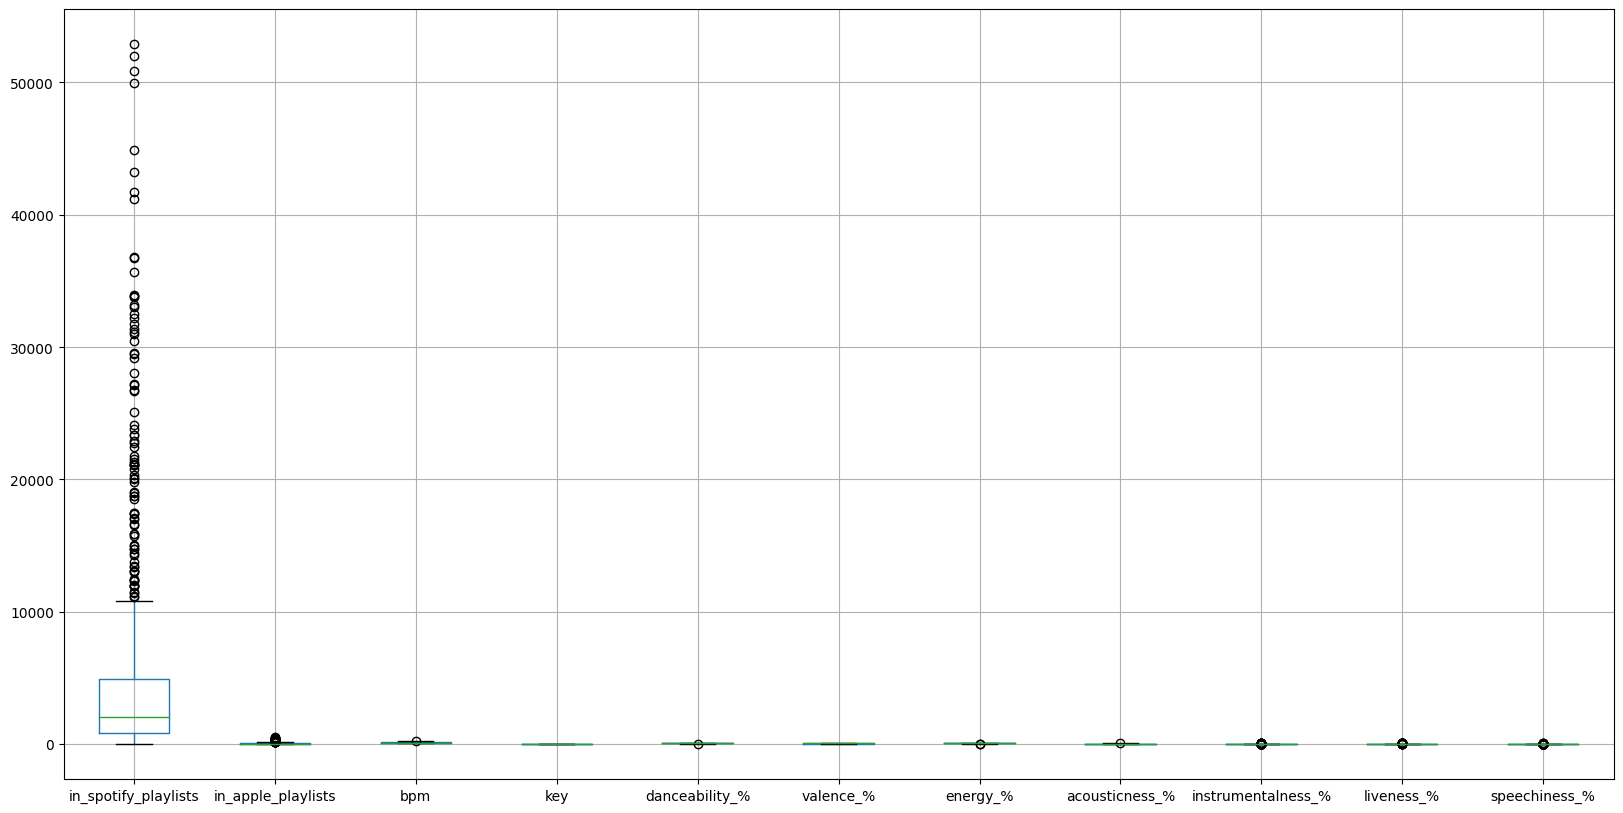

In [612]:
#we use bockplot to visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
spotify_df.boxplot()
plt.show()

In [613]:
#Using ANOVA to determine which variables are most important
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

X = spotify_df.loc[:, spotify_df.columns != 'streams']
Y = spotify_df.loc[:,'streams']

selector = SelectKBest(f_classif, k='all')
FeaturesS = selector.fit(X, Y)
np.set_printoptions(suppress=True)
print("Scores:", FeaturesS.scores_)
print("P values", FeaturesS.pvalues_)

Scores: [   4.04641408   69.41470616    0.38182645           inf    3.9529588
   76.42464224   19.87830201  120.1863519  3906.98268347           inf
   64.95949222   24.18866994]
P values [0.13660152 0.00236091 0.95020853 0.         0.14076249 0.00204608
 0.01491707 0.00104197 0.00000566 0.         0.00260559 0.01120271]


C:\Users\Garrett\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


We can remove some features based on these scores and boxplot.

In [614]:
spotify_df = spotify_df.loc[:, ['streams', 'key', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'liveness_%', 'speechiness_%']]
spotify_df.head(1000)

,streams,key,danceability_%,valence_%,energy_%,acousticness_%,liveness_%,speechiness_%
0,141381703,11,80,89,83,31,8,4
1,133716286,1,71,61,74,7,10,4
2,140003974,5,51,32,53,17,31,6
3,800840817,9,55,58,72,11,11,15
4,303236322,9,65,23,80,14,11,6
...,...,...,...,...,...,...,...,...
948,91473363,9,60,24,39,57,8,3
949,121871870,6,42,7,24,83,12,6
950,73513683,1,80,81,67,4,8,6
951,133895612,1,82,67,77,8,12,5


In [615]:
#now we split the data into training and testing sets
from sklearn.model_selection import train_test_split

X = spotify_df.loc[:, spotify_df.columns != 'streams']
Y = spotify_df.loc[:,'streams']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

#now we scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#next we train the model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
print("KNN accuracy: ", accuracy_score(Y_test, Y_pred))

#we can also try other models for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
print("Logistic regression accuracy: ", accuracy_score(Y_test, Y_pred))

dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
Y_pred = dt.predict(X_test)
print("Decision tree accuracy: ", accuracy_score(Y_test, Y_pred))

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
print("random forest accuracy: ", accuracy_score(Y_test, Y_pred))


KNN accuracy:  0.0040650406504065045
Logistic regression accuracy:  0.0
Decision tree accuracy:  0.0040650406504065045
random forest accuracy:  0.008130081300813009
